### Pip install

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot

import warnings
warnings.filterwarnings("ignore")

### Import data

Dataset must contain two columns:

- Datastamp or Timestamp. It should follow the format expected by Pandas, namely YYYY-MM-DD or YYYY-MM-DD HH:MM:SS.
- A numeric value.

In [7]:
PATH = 'https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv'

data = pd.read_csv(PATH)

In [8]:
data.head()

ds         y
0  2007-12-10  9.590761
1  2007-12-11  8.519590
2  2007-12-12  8.183677
3  2007-12-13  8.072467
4  2007-12-14  7.893572

In [9]:
data.tail()

ds          y
2900  2016-01-16   7.817223
2901  2016-01-17   9.273878
2902  2016-01-18  10.333775
2903  2016-01-19   9.125871
2904  2016-01-20   8.891374

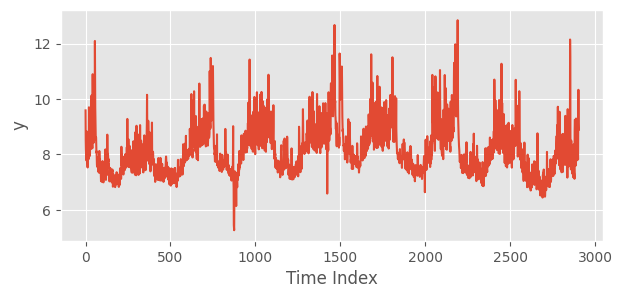

In [13]:
plt.figure(figsize = (7, 3))
plt.plot(data.y)
plt.ylabel('y')
plt.xlabel('Time Index');

In [14]:
model = Prophet()

In [15]:
# It is a linear additive model.
model.fit(data)

18:20:08 - cmdstanpy - INFO - Chain [1] start processing
18:20:11 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# It includes both the past values, i.e. the ones used for the fitting step,
# and the new ones. 

future = model.make_future_dataframe(periods = 365)
future.tail()

ds
3265 2017-01-15
3266 2017-01-16
3267 2017-01-17
3268 2017-01-18
3269 2017-01-19

In [17]:
forecast = model.predict(future)
# [['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast.tail()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
3265 2017-01-15  7.192273    7.461309    8.939328     6.806232     7.544603   
3266 2017-01-16  7.191251    7.841847    9.256312     6.803313     7.544588   
3267 2017-01-17  7.190229    7.548929    9.046501     6.800292     7.544573   
3268 2017-01-18  7.189207    7.446364    8.879735     6.797272     7.544904   
3269 2017-01-19  7.188185    7.413595    8.890881     6.794252     7.545632   

      additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
3265        1.017995              1.017995              1.017995  0.048287   
3266        1.344045              1.344045              1.344045  0.352293   
3267        1.132483              1.132483              1.132483  0.119630   
3268        0.966138              0.966138              0.966138 -0.066670   
3269        0.979119              0.979119              0.979119 -0.072252   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
3265      0.048287      0.048287  0.969708      0.969708      0.969708   
3266      0.352293      0.352293  0.991752      0.991752      0.991752   
3267      0.119630      0.119630  1.012853      1.012853      1.012853   
3268     -0.066670     -0.066670  1.032808      1.032808      1.032808   
3269     -0.072252     -0.072252  1.051372      1.051372      1.051372   

      multiplicative_terms  multiplicative_terms_lower  \
3265                   0.0                         0.0   
3266                   0.0                         0.0   
3267                   0.0                         0.0   
3268                   0.0                         0.0   
3269                   0.0                         0.0   

      multiplicative_terms_upper      yhat  
3265                         0.0  8.210268  
3266                         0.0  8.535296  
3267                         0.0  8.322712  
3268                         0.0  8.155345  
3269                         0.0  8.167304

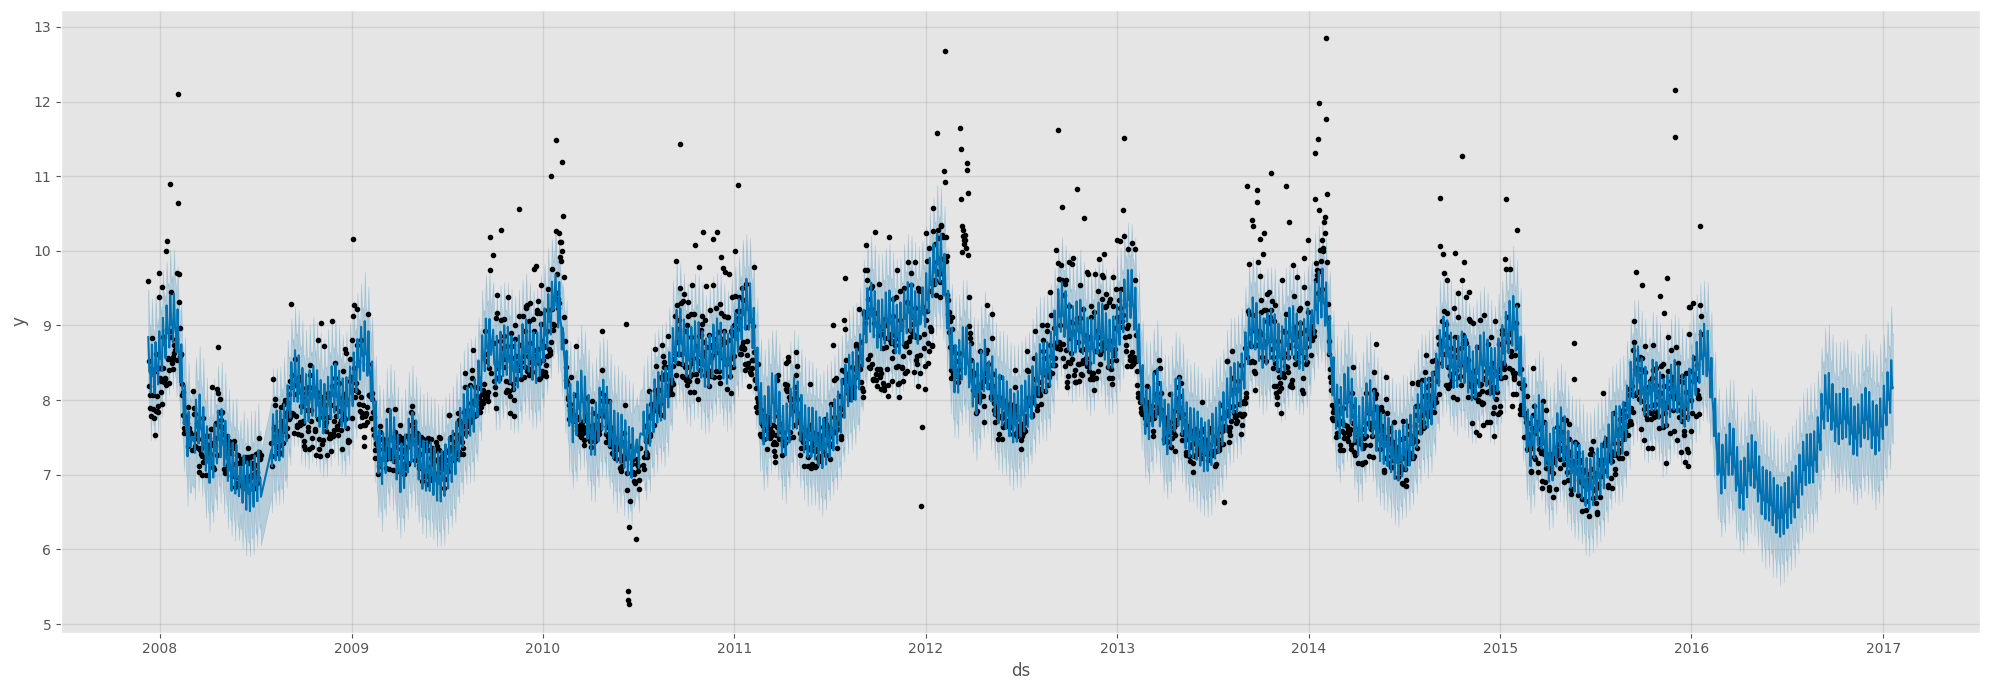

In [18]:
model.plot(forecast, figsize = (20, 7));

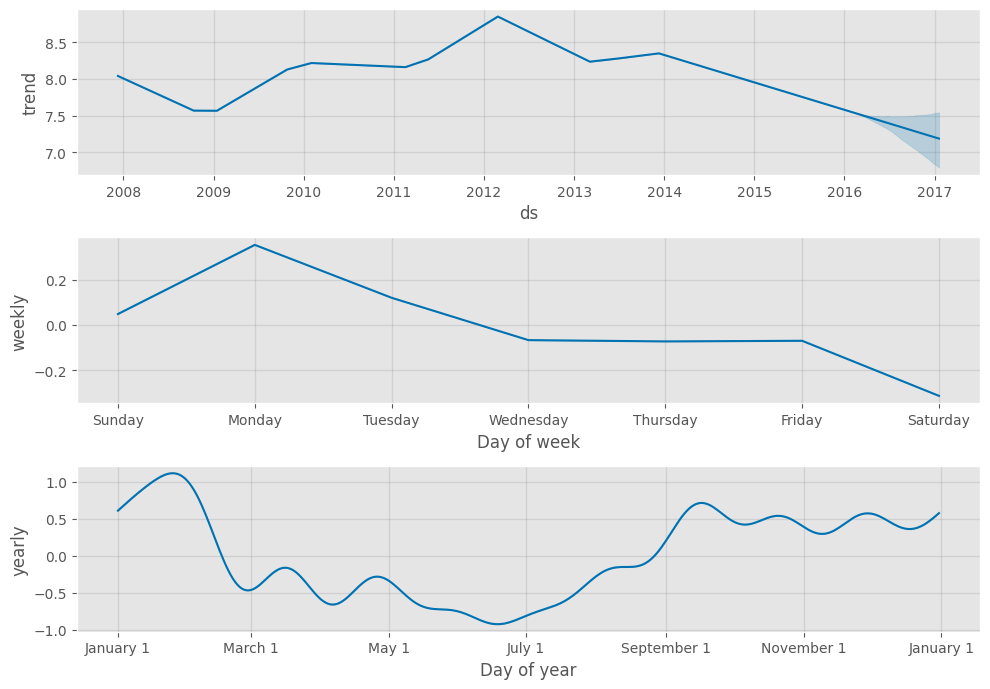

In [20]:
# By default, it shows the trend with the weekly and yearly seasonalities. 
model.plot_components(forecast, figsize = (10, 7));

In [22]:
plot_plotly(model, forecast)

In [15]:
plot_components_plotly(model, forecast)

### Forecasting growth

Sometimes the forecasted variable can saturate, e.g. total market size, total population etc. Prophet allows us to make forecasts using a logisitc growth trend model. 

In [61]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R.csv')

In [62]:
df.head()

ds         y
0  2008-01-30  5.976351
1  2008-01-16  6.049733
2  2008-01-17  6.011267
3  2008-01-14  5.953243
4  2008-01-15  5.910797

In [63]:
# Set the carrying capacity. It must be defined for each row.

df['cap'] = 8.5

In [64]:
model = Prophet(growth = 'logistic')
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [65]:
future = model.make_future_dataframe(365 * 5)
future['cap'] = 8.5
forecast = model.predict(future) 

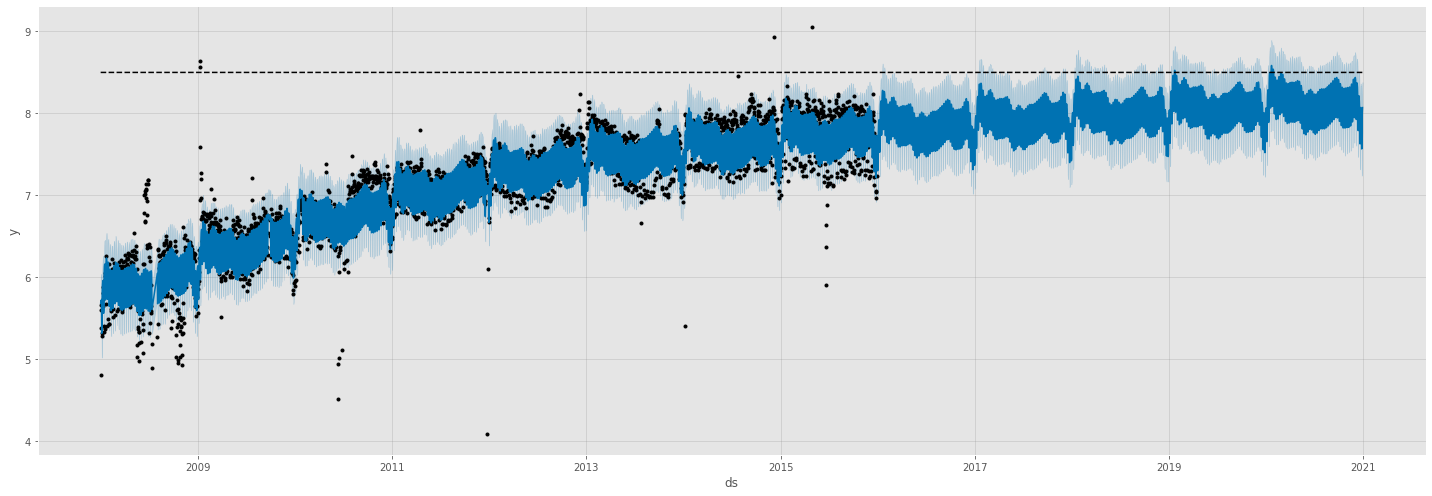

In [66]:
model.plot(forecast, figsize = (20, 7));

On the other hand, it is also possible to saturate the minimum. 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


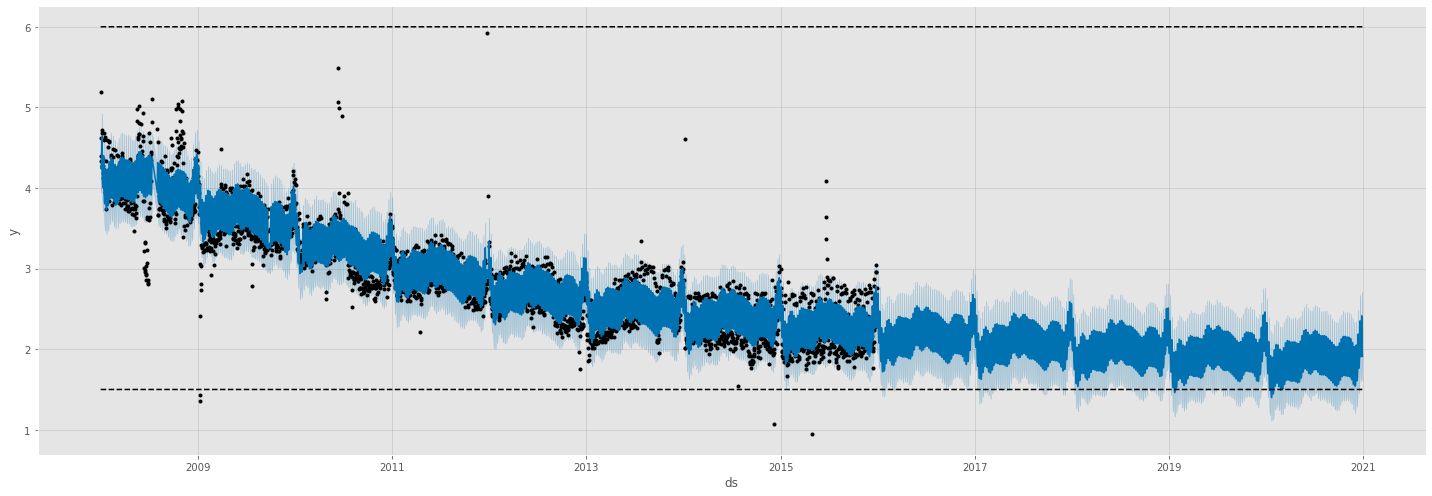

In [67]:
df['y'] = 10 - df['y']
df['cap'] = 6
df['floor'] = 1.5
future['cap'] = 6
future['floor'] = 1.5
model = Prophet(growth='logistic')
model.fit(df)
fcst = model.predict(future)
model.plot(fcst, figsize = (20, 7));

### Trend changepoints

Changepoints are used by prophet to detect abrupt changes in the trajectory. _n_changepoints_ quantifies the number of possible changepoints which will be chosen by a regularization approach.

Moreover, by default the changepoints are inferred for the first 80% of the time series in order to avoid overfitting fluctuations at the end of the time series. However, this percentage can be modified with *changepoint_range*. 

The strength of the regularization approach can be tuned with the *changepoint_prior_scale*: the more that value is, the less the regularization will be. 

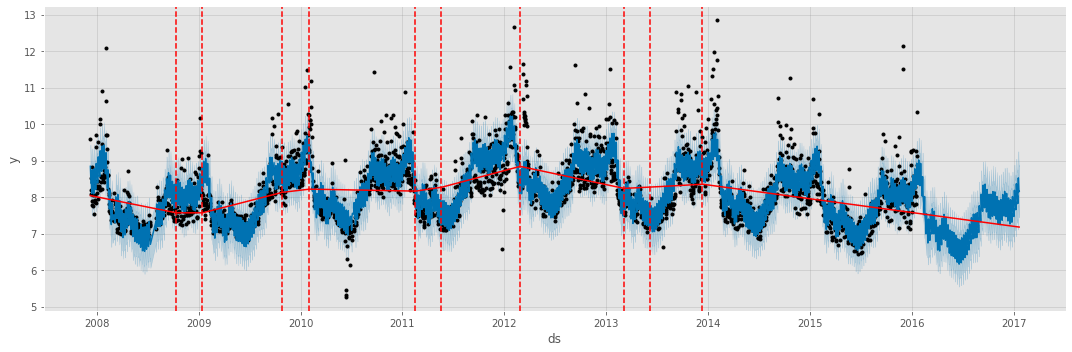

In [60]:
# Changepoints.
fig = model.plot(forecast, figsize = (15, 5))
add_changepoints_to_plot(fig.gca(), model, forecast);

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


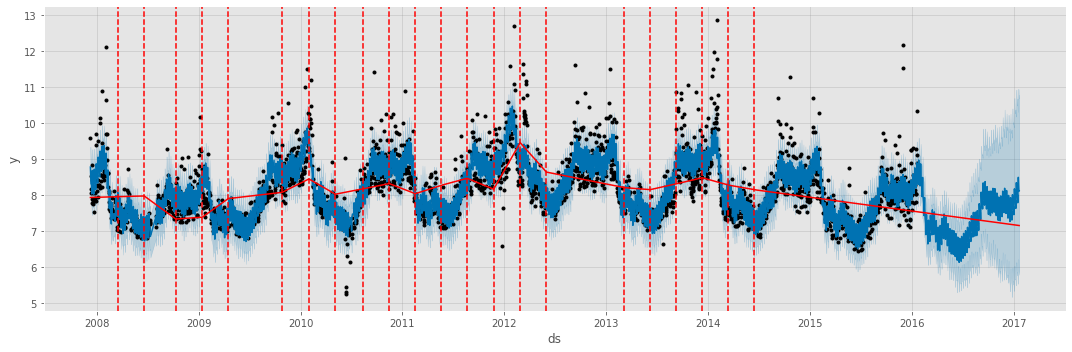

In [79]:
model = Prophet(changepoint_prior_scale = 0.5)
forecast = model.fit(data).predict(future)

fig = model.plot(forecast, figsize = (15, 5))
add_changepoints_to_plot(fig.gca(), model, forecast);

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


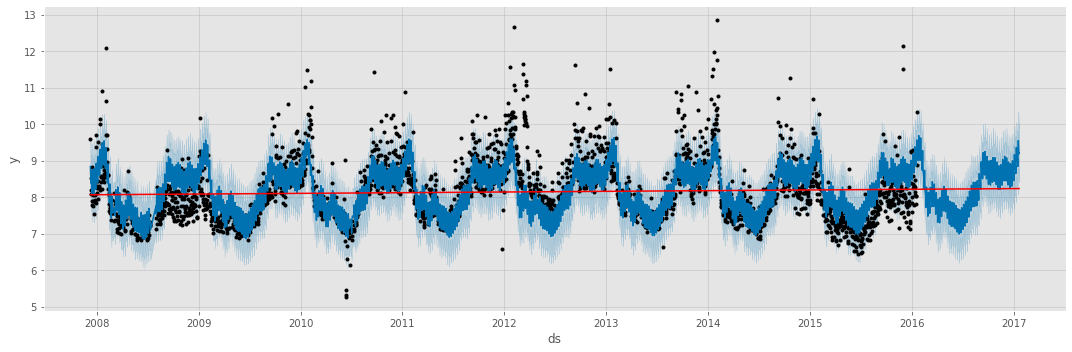

In [80]:
model = Prophet(changepoint_prior_scale = 0.0001)
forecast = model.fit(data).predict(future)

fig = model.plot(forecast, figsize = (15, 5))
add_changepoints_to_plot(fig.gca(), model, forecast);